# Imports

In [3]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from pyts.transformation import ShapeletTransform
from pyts.classification import KNeighborsClassifier as KNeighborsClassifier_pyts

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization
from keras.optimizers import Adagrad

from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate
from sktime.classification.interval_based import CanonicalIntervalForest

# Dataset Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
train_data = np.load('/content/drive/My Drive/RavdessAudioOnlyNumpy__X_train.npy')
#categorical_train = pd.read_csv('/content/drive/My Drive/RavdessAudioOnlyNumpy__Y_train.csv')
test_data = np.load('/content/drive/My Drive/RavdessAudioOnlyNumpy__X_test.npy')
#categorical_test = pd.read_csv('/content/drive/My Drive/RavdessAudioOnlyNumpy__Y_test.csv')

In [22]:
print(train_data.shape, test_data.shape)

(1828, 50718) (624, 50718)


In [ ]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [ ]:
print(train_data.shape, test_data.shape)
print(categorical_train.shape, categorical_test.shape)

In [ ]:
# computing the average length in TR
lengths = []
for index, row in train_data.iterrows():
  lengths.append(len(row.dropna()))
print(np.mean(lengths))

In [ ]:
new_train_data = train_data.loc[:, :32431]
new_test_data = test_data.loc[:, :32431]

In [ ]:
print(new_train_data.shape, new_test_data.shape)

In [ ]:
# function for replacing NaN with mean value of row

def replace_nan(df):
  new_rows = []
  for index, row in df.iterrows():
      new_row = []
      mean = np.mean(df.iloc[index].dropna())
      if np.isnan(mean):
          continue
      for value in row:
          if np.isnan(value):
              new_row.append(mean)
          else:
              new_row.append(value)
      new_rows.append(new_row)

  return pd.DataFrame(new_rows)

In [ ]:
filled_train = replace_nan(new_train_data)
filled_test = replace_nan(new_test_data)

In [ ]:
filled_train.to_csv('TS_X_train_reduced.csv')
filled_test.to_csv('TS_X_test_reduced.csv')

# Data Preparation

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
X_train = pd.read_csv('/content/drive/My Drive/TS_X_train_reduced.csv')
X_test = pd.read_csv('/content/drive/My Drive/TS_X_test_reduced.csv')
categorical_train = pd.read_csv('/content/drive/My Drive/RavdessAudioOnlyNumpy__Y_train.csv')
categorical_test = pd.read_csv('/content/drive/My Drive/RavdessAudioOnlyNumpy__Y_test.csv')

In [9]:
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_test.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
#scaler = TimeSeriesScalerMinMax() # di default normalizza per riga
#X_train = pd.DataFrame(scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1]))
#X_test = pd.DataFrame(scaler.fit_transform(X_test).reshape(X_test.shape[0], X_test.shape[1]))

In [11]:
#print(X_train.shape, X_test.shape)

In [12]:
# moving average
def moving_average(df, w):
  new_df = []
  for index, ts in df.iterrows():
    ts = (ts - ts.mean()/ts.std()).rolling(window=w).mean()
    new_df.append(ts)
  return pd.DataFrame(new_df)

In [13]:
X_train_ma = moving_average(X_train, 3)
X_train_ma.drop(['0', '1'], axis=1, inplace=True)

In [14]:
X_test_ma = moving_average(X_test, 3)
X_test_ma.drop(['0', '1'], axis=1, inplace=True)

In [15]:
print(X_train_ma.shape, X_test_ma.shape)

(1828, 32430) (624, 32430)


In [16]:
# rocket pre-processing
def rocket(array, num_kernels=10000, random_state=42, normalise=False):
  ts = [pd.Series(row) for row in array]
  df = pd.DataFrame()
  df['ts'] = ts
  rocket = Rocket(num_kernels=num_kernels, random_state=random_state, normalise=normalise)
  X = rocket.fit_transform(df)
  return X

In [17]:
def minirocket(array, num_kernels=10000, random_state=42, normalise=False):
  ts = [pd.Series(row) for row in array]
  df = pd.DataFrame()
  df['ts'] = ts
  rocket = MiniRocket(num_kernels=num_kernels, random_state=random_state, normalise=normalise)
  X = rocket.fit_transform(df)
  return X

In [18]:
X_train_rocket = rocket(X_train)
X_test_rocket = rocket(X_test)

In [19]:
print(X_train_rocket.shape, X_test_rocket.shape)

(32432, 20000) (32432, 20000)


In [20]:
def get_shapelets(X, y, window_sizes, random_state=42):
    st = ShapeletTransform(window_sizes=window_sizes,
                           random_state=random_state, sort=True)
    X_new = st.fit_transform(X_train)
    return X_new

# Target: **Vocal** **Channel**

## Data Preparation: PAA

In [172]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "song":
      new_array[i] = 1
  return new_array

In [173]:
y_train = categorical_train['vocal_channel']
y_test = categorical_test['vocal_channel']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [174]:
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

In [175]:
X_train = paa.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [176]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [177]:
X_test = paa.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [178]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [179]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [180]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


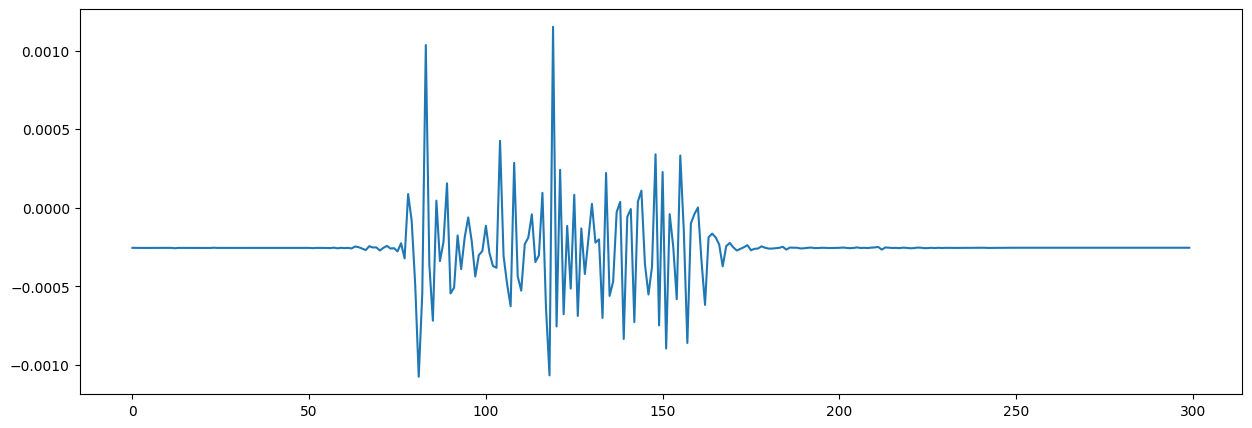

In [181]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Data Preparation: SAX

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "song":
      new_array[i] = 1
  return new_array

In [ ]:
y_train = categorical_train['vocal_channel']
y_test = categorical_test['vocal_channel']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [ ]:
n_segments = 1000
alphabet_size_avg = 50
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=alphabet_size_avg)

In [ ]:
X_train = sax.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_train.shape, y_train.shape)

(1828, 1000) (1828,)


In [ ]:
X_test = sax.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_test.shape, y_test.shape)

(624, 1000) (624,)


In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 1000) (1462,)
(366, 1000) (366,)


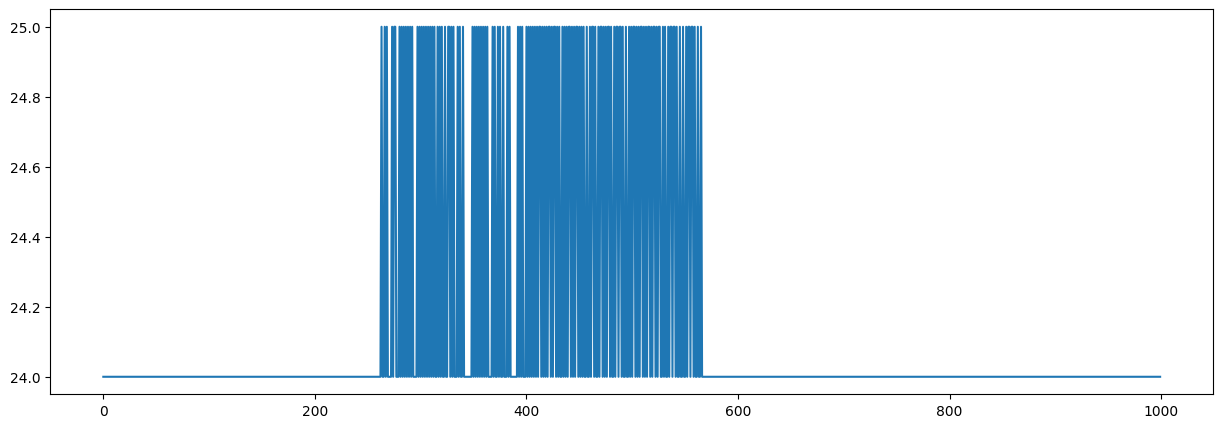

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Training

In [ ]:
# KNN Minkowski
param_grid = {'n_neighbors': np.arange(2, X_train.shape[0]//2),
              'metric': ['euclidean', 'cityblock'],
              'weights': ['uniform', 'distance']
              }

search = RandomizedSearchCV(KNeighborsClassifier(),
                      param_grid,
                      cv=KFold(3, shuffle=True, random_state=42),
                      n_iter=100,
                      n_jobs=-1,
                      scoring='accuracy'
                      )
search.fit(X_train, y_train)
print(search.best_score_, search.best_estimator_)

0.5919208233510099 KNeighborsClassifier(metric='euclidean', n_neighbors=20, weights='distance')


In [ ]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.99      0.74       360
         1.0       0.74      0.05      0.10       264

    accuracy                           0.59       624
   macro avg       0.66      0.52      0.42       624
weighted avg       0.65      0.59      0.47       624



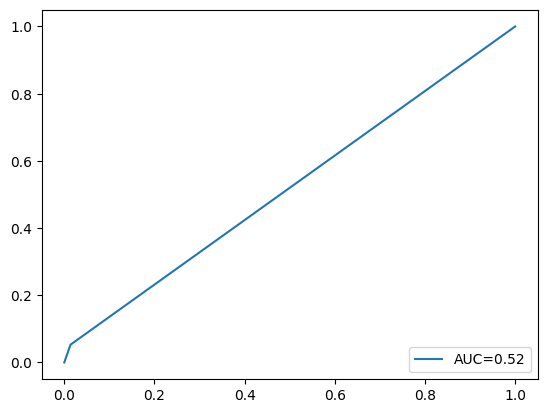

In [ ]:
# ROC
y_pred_proba = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

In [ ]:
# KNN DTW: with PAA = 300 about 6 mins
clf = KNeighborsClassifier_pyts(n_neighbors=700, 
                                metric='dtw_sakoechiba', 
                                weights='distance',
                                n_jobs=-1,
                                metric_params={'window_size': 0.1})
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.84      0.73       216
         1.0       0.61      0.36      0.45       150

    accuracy                           0.64       366
   macro avg       0.63      0.60      0.59       366
weighted avg       0.63      0.64      0.62       366



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.93      0.80       360
         1.0       0.82      0.47      0.59       264

    accuracy                           0.73       624
   macro avg       0.76      0.70      0.70       624
weighted avg       0.75      0.73      0.71       624



In [ ]:
# CIF
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       216
         1.0       0.88      0.95      0.92       150

    accuracy                           0.93       366
   macro avg       0.92      0.93      0.93       366
weighted avg       0.93      0.93      0.93       366



In [ ]:
clf = CanonicalIntervalForest(n_estimators=100)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       216
         1.0       0.89      0.97      0.93       150

    accuracy                           0.94       366
   macro avg       0.93      0.94      0.94       366
weighted avg       0.94      0.94      0.94       366



### Shapelet-Based

In [182]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 300
n_classes 2
shapelet_sizes {30: 5}


In [183]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0)

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [184]:
X_train_shap = shp_clf.fit_transform(X_train, y_train)
X_test_shap = shp_clf.fit_transform(X_test, y_test)

In [185]:
print(X_train_shap.shape)
print(X_test_shap.shape)

(1828, 5)
(624, 5)


In [186]:
# train-val split
X_train_shap2, X_val_shap, y_train_shap2, y_val_shap = train_test_split(X_train_shap, y_train, test_size=0.2, shuffle=True, random_state=42)

In [187]:
print(X_train_shap2.shape, y_train_shap2.shape)
print(X_val_shap.shape, y_val_shap.shape)

(1462, 5) (1462,)
(366, 5) (366,)


In [188]:
param_grid = {
    "min_samples_split": sp.loguniform(1e-2, 1e0),
    "min_samples_leaf": sp.uniform(0.001, 0.2),
    "max_depth": sp.randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"], 
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6263641013217045 DecisionTreeClassifier(max_depth=119, min_samples_leaf=0.05313547777395396,
                       min_samples_split=0.01092945265171169)


In [189]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.88      0.73       203
         1.0       0.70      0.36      0.47       163

    accuracy                           0.64       366
   macro avg       0.66      0.62      0.60       366
weighted avg       0.66      0.64      0.62       366



In [190]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73       360
         1.0       0.00      0.00      0.00       264

    accuracy                           0.58       624
   macro avg       0.29      0.50      0.37       624
weighted avg       0.33      0.58      0.42       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [191]:
param_grid = {
              'n_neighbors': np.arange(2, X_train_shap.shape[0]//2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'cityblock']
             }

search = RandomizedSearchCV(KNeighborsClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6220050786472494 KNeighborsClassifier(metric='cityblock', n_neighbors=51)


In [192]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.86      0.71       203
         1.0       0.64      0.30      0.41       163

    accuracy                           0.61       366
   macro avg       0.62      0.58      0.56       366
weighted avg       0.62      0.61      0.58       366



In [193]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73       360
         1.0       0.00      0.00      0.00       264

    accuracy                           0.58       624
   macro avg       0.29      0.50      0.37       624
weighted avg       0.33      0.58      0.42       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Rocket

In [94]:
# train-val split
X_train_mr2, X_val_mr, y_train_mr2, y_val_mr = train_test_split(X_train_rocket, y_train, test_size=0.2, shuffle=True, random_state=42)

In [95]:
print(X_train_mr2.shape, y_train_mr2.shape)
print(X_val_mr.shape, y_val_mr.shape)

(1462, 20000) (1462,)
(366, 20000) (366,)


In [111]:
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_mr2, y_train_mr2)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [112]:
y_pred = clf.predict(X_val_mr)
print(classification_report(y_pred, y_val_mr))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       215
         1.0       0.82      0.89      0.85       151

    accuracy                           0.87       366
   macro avg       0.87      0.88      0.87       366
weighted avg       0.88      0.87      0.87       366



In [113]:
y_pred = clf.predict(X_test_rocket)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       349
         1.0       0.94      0.90      0.92       275

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



# Target: **Sex** 

## Data Preparation: PAA

In [194]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [195]:
y_train = categorical_train['sex']
y_test = categorical_test['sex']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [196]:
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

In [197]:
X_train = paa.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [198]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [199]:
X_test = paa.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [200]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [201]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [202]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


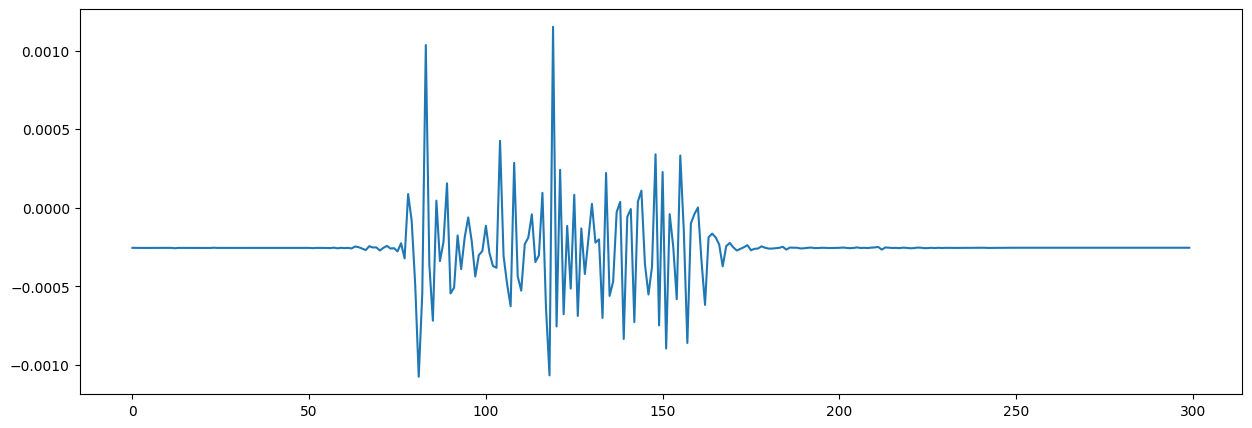

In [203]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Data Preparation: SAX

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [ ]:
y_train = categorical_train['sex']
y_test = categorical_test['sex']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [ ]:
n_segments = 300
alphabet_size_avg = 10
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=alphabet_size_avg)

In [ ]:
X_train = sax.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [ ]:
X_test = sax.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


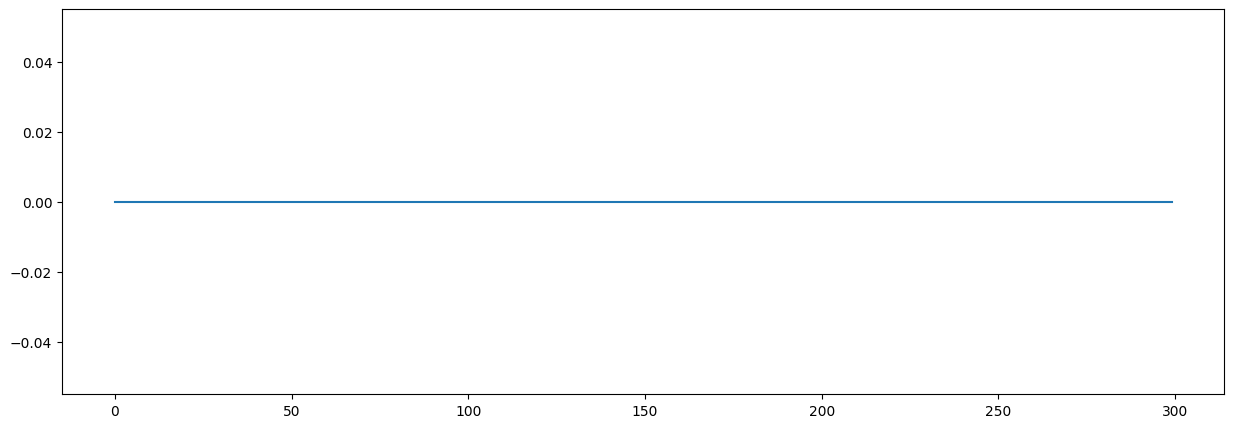

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Training

In [ ]:
# KNN Minkowski
param_grid = {'n_neighbors': np.arange(2, X_train.shape[0]//2),
              'metric': ['euclidean', 'cityblock'],
              'weights': ['uniform', 'distance']
              }

search = RandomizedSearchCV(KNeighborsClassifier(),
                      param_grid,
                      cv=KFold(3, shuffle=True, random_state=42),
                      n_iter=100,
                      n_jobs=-1,
                      scoring='accuracy'
                      )
search.fit(X_train, y_train)
print(search.best_score_, search.best_estimator_)

0.6465997290191751 KNeighborsClassifier(metric='cityblock', n_neighbors=34)


In [ ]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67       312
         1.0       0.68      0.35      0.46       312

    accuracy                           0.59       624
   macro avg       0.62      0.59      0.56       624
weighted avg       0.62      0.59      0.56       624



In [ ]:
# KNN DTW: with PAA = 300 about 6 mins
clf = KNeighborsClassifier_pyts(n_neighbors=67, 
                                metric='dtw_sakoechiba', 
                                weights='distance',
                                n_jobs=-1,
                                metric_params={'window_size': 0.1})
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73       179
         1.0       0.76      0.64      0.69       187

    accuracy                           0.71       366
   macro avg       0.72      0.71      0.71       366
weighted avg       0.72      0.71      0.71       366



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.92      0.76       312
         1.0       0.86      0.49      0.62       312

    accuracy                           0.71       624
   macro avg       0.75      0.71      0.69       624
weighted avg       0.75      0.71      0.69       624



In [ ]:
# CIF
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80       179
         1.0       0.79      0.87      0.83       187

    accuracy                           0.81       366
   macro avg       0.82      0.81      0.81       366
weighted avg       0.82      0.81      0.81       366



In [34]:
clf = CanonicalIntervalForest(n_estimators=100)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       179
         1.0       0.78      0.88      0.83       187

    accuracy                           0.81       366
   macro avg       0.82      0.81      0.81       366
weighted avg       0.82      0.81      0.81       366



### Shapelet-Based

In [204]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 300
n_classes 2
shapelet_sizes {30: 5}


In [205]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0)

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [206]:
X_train_shap = shp_clf.fit_transform(X_train, y_train)
X_test_shap = shp_clf.fit_transform(X_test, y_test)

In [207]:
print(X_train_shap.shape)
print(X_test_shap.shape)

(1828, 5)
(624, 5)


In [208]:
# train-val split
X_train_shap2, X_val_shap, y_train_shap2, y_val_shap = train_test_split(X_train_shap, y_train, test_size=0.2, shuffle=True, random_state=42)

In [209]:
print(X_train_shap2.shape, y_train_shap2.shape)
print(X_val_shap.shape, y_val_shap.shape)

(1462, 5) (1462,)
(366, 5) (366,)


In [210]:
param_grid = {
    "min_samples_split": sp.loguniform(1e-2, 1e0),
    "min_samples_leaf": sp.uniform(0.001, 0.2),
    "max_depth": sp.randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"], 
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6701364774287328 DecisionTreeClassifier(criterion='log_loss', max_depth=14,
                       min_samples_leaf=0.029115215873569158,
                       min_samples_split=0.28147717896311536)


In [211]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.63      0.65       175
         1.0       0.68      0.72      0.70       191

    accuracy                           0.68       366
   macro avg       0.68      0.68      0.68       366
weighted avg       0.68      0.68      0.68       366



In [212]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       312
         1.0       0.50      1.00      0.67       312

    accuracy                           0.50       624
   macro avg       0.25      0.50      0.33       624
weighted avg       0.25      0.50      0.33       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
param_grid = {
              'n_neighbors': np.arange(2, X_train_shap.shape[0]//2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'cityblock']
             }

search = RandomizedSearchCV(KNeighborsClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6285669421339292 KNeighborsClassifier(metric='cityblock', n_neighbors=15, weights='distance')


In [214]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       175
         1.0       1.00      1.00      1.00       191

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



In [215]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       312
         1.0       0.50      1.00      0.67       312

    accuracy                           0.50       624
   macro avg       0.25      0.50      0.33       624
weighted avg       0.25      0.50      0.33       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Rocket

In [135]:
# train-val split
X_train_mr2, X_val_mr, y_train_mr2, y_val_mr = train_test_split(X_train_rocket, y_train, test_size=0.2, shuffle=True, random_state=42)

In [136]:
print(X_train_mr2.shape, y_train_mr2.shape)
print(X_val_mr.shape, y_val_mr.shape)

(1462, 20000) (1462,)
(366, 20000) (366,)


In [137]:
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_mr2, y_train_mr2)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [138]:
y_pred = clf.predict(X_val_mr)
print(classification_report(y_pred, y_val_mr))

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       176
         1.0       0.75      0.75      0.75       190

    accuracy                           0.74       366
   macro avg       0.74      0.74      0.74       366
weighted avg       0.74      0.74      0.74       366



In [139]:
y_pred = clf.predict(X_test_rocket)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74       420
         1.0       0.52      0.79      0.63       204

    accuracy                           0.69       624
   macro avg       0.69      0.72      0.68       624
weighted avg       0.75      0.69      0.70       624



# Target: **Emotional Intensity** 

## Data Preparation: PAA

In [216]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "strong":
      new_array[i] = 1
  return new_array

In [217]:
y_train = categorical_train['emotional_intensity']
y_test = categorical_test['emotional_intensity']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [218]:
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

In [219]:
X_train = paa.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [220]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [221]:
X_test = paa.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [222]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [223]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [224]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


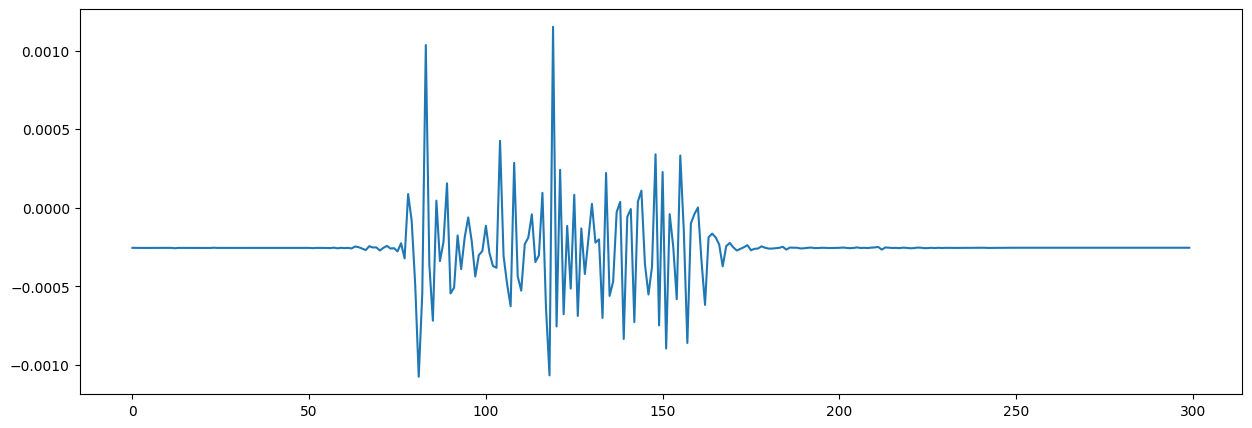

In [225]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Data Preparation: SAX

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [ ]:
y_train = categorical_train['sex']
y_test = categorical_test['sex']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [ ]:
n_segments = 300
alphabet_size_avg = 10
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=alphabet_size_avg)

In [ ]:
X_train = sax.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [ ]:
X_test = sax.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


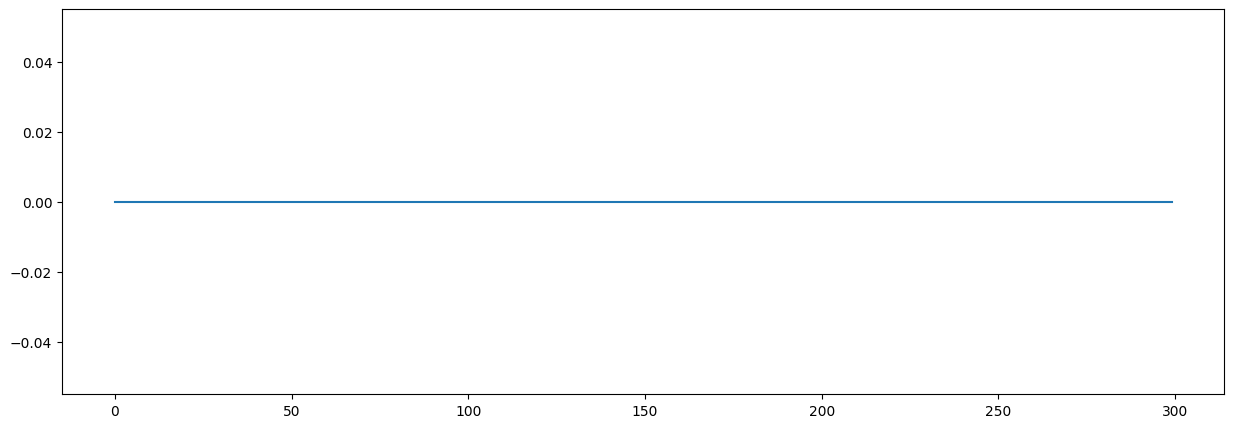

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Training

In [45]:
# KNN Minkowski
param_grid = {'n_neighbors': np.arange(2, X_train.shape[0]//2),
              'metric': ['euclidean', 'cityblock'],
              'weights': ['uniform', 'distance']
              }

search = RandomizedSearchCV(KNeighborsClassifier(),
                      param_grid,
                      cv=KFold(3, shuffle=True, random_state=42),
                      n_iter=100,
                      n_jobs=-1,
                      scoring='accuracy'
                      )
search.fit(X_train, y_train)
print(search.best_score_, search.best_estimator_)

0.5475903344190513 KNeighborsClassifier(metric='euclidean', n_neighbors=105, weights='distance')


In [46]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       336
         1.0       0.00      0.00      0.00       288

    accuracy                           0.54       624
   macro avg       0.27      0.50      0.35       624
weighted avg       0.29      0.54      0.38       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# KNN DTW: with PAA = 300 about 6 mins
clf = KNeighborsClassifier_pyts(n_neighbors=67, 
                                metric='dtw_sakoechiba', 
                                weights='distance',
                                n_jobs=-1,
                                metric_params={'window_size': 0.1})
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73       197
         1.0       0.75      0.37      0.49       169

    accuracy                           0.65       366
   macro avg       0.68      0.63      0.61       366
weighted avg       0.68      0.65      0.62       366



In [48]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.94      0.74       336
         1.0       0.80      0.28      0.42       288

    accuracy                           0.64       624
   macro avg       0.70      0.61      0.58       624
weighted avg       0.70      0.64      0.59       624



In [49]:
# CIF
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75       197
         1.0       0.73      0.62      0.67       169

    accuracy                           0.72       366
   macro avg       0.72      0.71      0.71       366
weighted avg       0.72      0.72      0.71       366



In [50]:
clf = CanonicalIntervalForest(n_estimators=100)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75       197
         1.0       0.73      0.59      0.65       169

    accuracy                           0.71       366
   macro avg       0.71      0.70      0.70       366
weighted avg       0.71      0.71      0.70       366



### Shapelet-Based

In [226]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 300
n_classes 2
shapelet_sizes {30: 5}


In [227]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0)

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [228]:
X_train_shap = shp_clf.fit_transform(X_train, y_train)
X_test_shap = shp_clf.fit_transform(X_test, y_test)

In [229]:
print(X_train_shap.shape)
print(X_test_shap.shape)

(1828, 5)
(624, 5)


In [230]:
# train-val split
X_train_shap2, X_val_shap, y_train_shap2, y_val_shap = train_test_split(X_train_shap, y_train, test_size=0.2, shuffle=True, random_state=42)

In [231]:
print(X_train_shap2.shape, y_train_shap2.shape)
print(X_val_shap.shape, y_val_shap.shape)

(1462, 5) (1462,)
(366, 5) (366,)


In [232]:
param_grid = {
    "min_samples_split": sp.loguniform(1e-2, 1e0),
    "min_samples_leaf": sp.uniform(0.001, 0.2),
    "max_depth": sp.randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"], 
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6559171624180103 DecisionTreeClassifier(criterion='entropy', max_depth=55,
                       min_samples_leaf=0.048758851197231425,
                       min_samples_split=0.38050797554741744)


In [233]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.81      0.73       202
         1.0       0.67      0.49      0.57       164

    accuracy                           0.66       366
   macro avg       0.67      0.65      0.65       366
weighted avg       0.67      0.66      0.65       366



In [234]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       336
         1.0       0.46      1.00      0.63       288

    accuracy                           0.46       624
   macro avg       0.23      0.50      0.32       624
weighted avg       0.21      0.46      0.29       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [235]:
param_grid = {
              'n_neighbors': np.arange(2, X_train_shap.shape[0]//2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'cityblock']
             }

search = RandomizedSearchCV(KNeighborsClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.6706757472161655 KNeighborsClassifier(metric='cityblock', n_neighbors=112)


In [236]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.73      0.71       202
         1.0       0.65      0.61      0.63       164

    accuracy                           0.68       366
   macro avg       0.67      0.67      0.67       366
weighted avg       0.68      0.68      0.68       366



In [237]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       336
         1.0       0.46      1.00      0.63       288

    accuracy                           0.46       624
   macro avg       0.23      0.50      0.32       624
weighted avg       0.21      0.46      0.29       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Rocket

In [154]:
# train-val split
X_train_mr2, X_val_mr, y_train_mr2, y_val_mr = train_test_split(X_train_rocket, y_train, test_size=0.2, shuffle=True, random_state=42)

In [155]:
print(X_train_mr2.shape, y_train_mr2.shape)
print(X_val_mr.shape, y_val_mr.shape)

(1462, 20000) (1462,)
(366, 20000) (366,)


In [156]:
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_mr2, y_train_mr2)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [157]:
y_pred = clf.predict(X_val_mr)
print(classification_report(y_pred, y_val_mr))

              precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       243
         1.0       0.52      0.70      0.60       123

    accuracy                           0.69       366
   macro avg       0.67      0.69      0.67       366
weighted avg       0.72      0.69      0.69       366



In [158]:
y_pred = clf.predict(X_test_rocket)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.79      0.65      0.72       407
         1.0       0.51      0.68      0.58       217

    accuracy                           0.66       624
   macro avg       0.65      0.67      0.65       624
weighted avg       0.69      0.66      0.67       624



# Target: **Emotion** 

## Data Preparation: PAA

In [238]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "calm":
      new_array[i] = 1
    elif array[i] == "happy":
      new_array[i] = 2
    elif array[i] == "sad":
      new_array[i] = 3
    elif array[i] == "angry":
      new_array[i] = 4
    elif array[i] == "fearful":
      new_array[i] = 5
    elif array[i] == "disgust":
      new_array[i] = 6
    elif array[i] == "surprised":
      new_array[i] = 7
  return new_array

In [239]:
y_train = categorical_train['emotion']
y_test = categorical_test['emotion']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [240]:
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

In [241]:
X_train = paa.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [242]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [243]:
X_test = paa.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [244]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [245]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [246]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


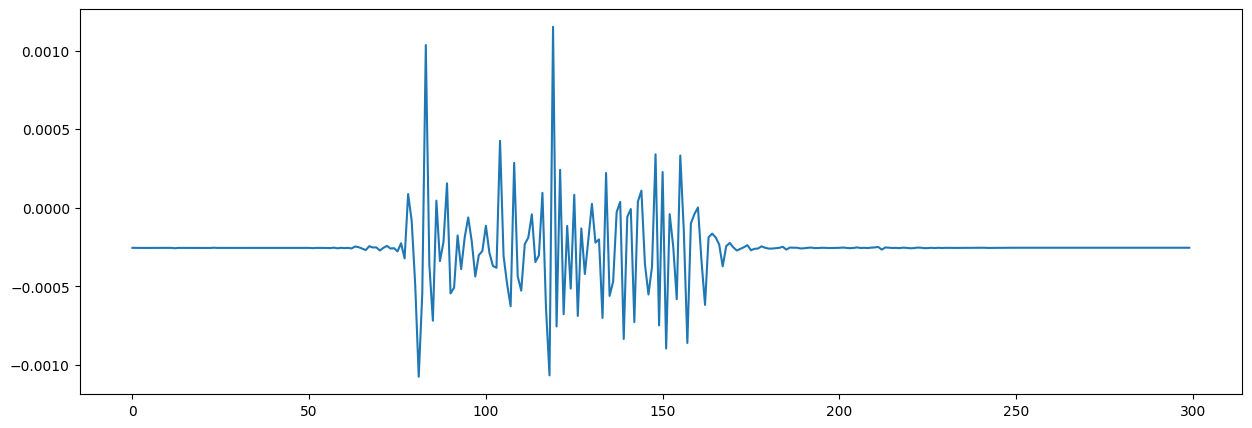

In [247]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Data Preparation: SAX

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [ ]:
y_train = categorical_train['sex']
y_test = categorical_test['sex']
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

In [ ]:
n_segments = 300
alphabet_size_avg = 10
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=alphabet_size_avg)

In [ ]:
X_train = sax.fit_transform(X_train_ma)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_train.shape, y_train.shape)

(1828, 300) (1828,)


In [ ]:
X_test = sax.fit_transform(X_test_ma)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [ ]:
print(X_test.shape, y_test.shape)

(624, 300) (624,)


In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 300) (1462,)
(366, 300) (366,)


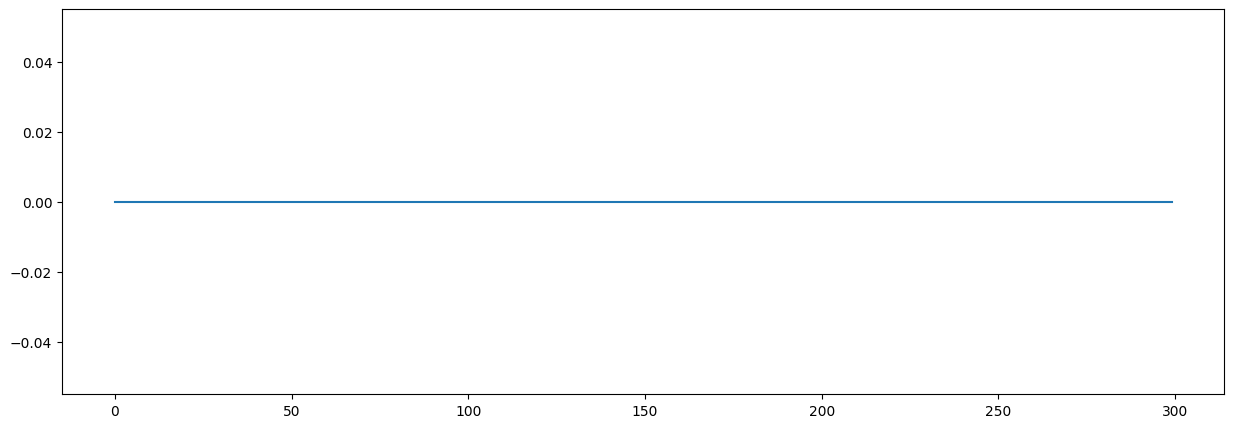

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[0])
plt.show()

## Training

In [61]:
# KNN Minkowski
param_grid = {'n_neighbors': np.arange(2, X_train.shape[0]//2),
              'metric': ['euclidean', 'cityblock'],
              'weights': ['uniform', 'distance']
              }

search = RandomizedSearchCV(KNeighborsClassifier(),
                      param_grid,
                      cv=KFold(3, shuffle=True, random_state=42),
                      n_iter=100,
                      n_jobs=-1,
                      scoring='accuracy'
                      )
search.fit(X_train, y_train)
print(search.best_score_, search.best_estimator_)

0.18270926987716132 KNeighborsClassifier(metric='euclidean', n_neighbors=73, weights='distance')


In [62]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.09      0.04      0.06        48
         1.0       0.25      0.59      0.35        96
         2.0       0.12      0.01      0.02        96
         3.0       0.15      0.54      0.23        96
         4.0       1.00      0.02      0.04        96
         5.0       0.00      0.00      0.00        96
         6.0       0.00      0.00      0.00        48
         7.0       0.00      0.00      0.00        48

    accuracy                           0.18       624
   macro avg       0.20      0.15      0.09       624
weighted avg       0.24      0.18      0.10       624



In [63]:
# KNN DTW: with PAA = 300 about 6 mins
clf = KNeighborsClassifier_pyts(n_neighbors=67, 
                                metric='dtw_sakoechiba', 
                                weights='distance',
                                n_jobs=-1,
                                metric_params={'window_size': 0.1})
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.22      0.14      0.17        28
         1.0       0.30      0.73      0.42        56
         2.0       0.16      0.16      0.16        56
         3.0       0.18      0.16      0.17        56
         4.0       0.39      0.43      0.41        56
         5.0       0.38      0.16      0.23        56
         6.0       0.29      0.07      0.11        29
         7.0       0.21      0.10      0.14        29

    accuracy                           0.28       366
   macro avg       0.27      0.24      0.23       366
weighted avg       0.27      0.28      0.25       366



In [64]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.17      0.10      0.13        48
         1.0       0.38      0.70      0.49        96
         2.0       0.30      0.41      0.35        96
         3.0       0.28      0.39      0.32        96
         4.0       0.59      0.50      0.54        96
         5.0       0.42      0.10      0.17        96
         6.0       0.32      0.12      0.18        48
         7.0       0.48      0.33      0.40        48

    accuracy                           0.37       624
   macro avg       0.37      0.33      0.32       624
weighted avg       0.38      0.37      0.34       624



In [65]:
# CIF
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.18      0.24        28
         1.0       0.57      0.75      0.65        56
         2.0       0.32      0.29      0.30        56
         3.0       0.31      0.30      0.31        56
         4.0       0.41      0.57      0.48        56
         5.0       0.39      0.39      0.39        56
         6.0       0.38      0.10      0.16        29
         7.0       0.29      0.31      0.30        29

    accuracy                           0.40       366
   macro avg       0.38      0.36      0.35       366
weighted avg       0.39      0.40      0.38       366



In [66]:
clf = CanonicalIntervalForest(n_estimators=100)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.21      0.29        28
         1.0       0.45      0.70      0.55        56
         2.0       0.35      0.32      0.33        56
         3.0       0.32      0.32      0.32        56
         4.0       0.47      0.66      0.55        56
         5.0       0.50      0.36      0.42        56
         6.0       0.67      0.07      0.12        29
         7.0       0.28      0.34      0.31        29

    accuracy                           0.41       366
   macro avg       0.43      0.37      0.36       366
weighted avg       0.43      0.41      0.39       366



### Shapelet-Based

In [248]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 300
n_classes 8
shapelet_sizes {30: 6}


In [249]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0)

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [250]:
X_train_shap = shp_clf.fit_transform(X_train, y_train)
X_test_shap = shp_clf.fit_transform(X_test, y_test)

In [251]:
print(X_train_shap.shape)
print(X_test_shap.shape)

(1828, 6)
(624, 6)


In [252]:
# train-val split
X_train_shap2, X_val_shap, y_train_shap2, y_val_shap = train_test_split(X_train_shap, y_train, test_size=0.2, shuffle=True, random_state=42)

In [253]:
print(X_train_shap2.shape, y_train_shap2.shape)
print(X_val_shap.shape, y_val_shap.shape)

(1462, 6) (1462,)
(366, 6) (366,)


In [254]:
param_grid = {
    "min_samples_split": sp.loguniform(1e-2, 1e0),
    "min_samples_leaf": sp.uniform(0.001, 0.2),
    "max_depth": sp.randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"], 
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.2576695649052913 DecisionTreeClassifier(max_depth=93, min_samples_leaf=0.06707841308880083,
                       min_samples_split=0.27845073317963936)


In [255]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
         1.0       0.38      0.64      0.47        70
         2.0       0.15      0.40      0.21        45
         3.0       0.00      0.00      0.00        57
         4.0       0.31      0.56      0.40        54
         5.0       0.31      0.14      0.19        59
         6.0       0.00      0.00      0.00        29
         7.0       0.00      0.00      0.00        18

    accuracy                           0.28       366
   macro avg       0.14      0.22      0.16       366
weighted avg       0.19      0.28      0.21       366



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [256]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        48
         1.0       0.00      0.00      0.00        96
         2.0       0.00      0.00      0.00        96
         3.0       0.00      0.00      0.00        96
         4.0       0.15      1.00      0.27        96
         5.0       0.00      0.00      0.00        96
         6.0       0.00      0.00      0.00        48
         7.0       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.02      0.12      0.03       624
weighted avg       0.02      0.15      0.04       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [257]:
param_grid = {
              'n_neighbors': np.arange(2, X_train_shap.shape[0]//2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'cityblock']
             }

search = RandomizedSearchCV(KNeighborsClassifier(),
                            param_distributions=param_grid,
                            cv=KFold(3, shuffle=True, random_state=42),
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train_shap, y_train)
print(search.best_score_, search.best_estimator_)

0.25929724443008784 KNeighborsClassifier(metric='cityblock', n_neighbors=197, weights='distance')


In [258]:
clf = search.best_estimator_
y_pred = clf.predict(X_val_shap)
print(classification_report(y_val_shap, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        34
         1.0       1.00      1.00      1.00        70
         2.0       1.00      1.00      1.00        45
         3.0       1.00      1.00      1.00        57
         4.0       1.00      1.00      1.00        54
         5.0       1.00      1.00      1.00        59
         6.0       1.00      1.00      1.00        29
         7.0       1.00      1.00      1.00        18

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



In [259]:
clf = search.best_estimator_
y_pred = clf.predict(X_test_shap)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        48
         1.0       0.00      0.00      0.00        96
         2.0       0.00      0.00      0.00        96
         3.0       0.00      0.00      0.00        96
         4.0       0.15      1.00      0.27        96
         5.0       0.00      0.00      0.00        96
         6.0       0.00      0.00      0.00        48
         7.0       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.02      0.12      0.03       624
weighted avg       0.02      0.15      0.04       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Rocket

In [172]:
# train-val split
X_train_mr2, X_val_mr, y_train_mr2, y_val_mr = train_test_split(X_train_rocket, y_train, test_size=0.2, shuffle=True, random_state=42)

In [173]:
print(X_train_mr2.shape, y_train_mr2.shape)
print(X_val_mr.shape, y_val_mr.shape)

(1462, 20000) (1462,)
(366, 20000) (366,)


In [180]:
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_mr2, y_train_mr2)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [181]:
y_pred = clf.predict(X_val_mr)
print(classification_report(y_pred, y_val_mr))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.39      0.50       132
         2.0       0.44      0.24      0.31        84
         3.0       0.05      0.08      0.06        36
         4.0       0.61      0.36      0.46        91
         5.0       0.05      0.25      0.08        12
         6.0       0.00      0.00      0.00         0
         7.0       0.17      0.27      0.21        11

    accuracy                           0.31       366
   macro avg       0.26      0.20      0.20       366
weighted avg       0.53      0.31      0.38       366



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [183]:
y_pred = clf.predict(X_test_rocket)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.52      0.29      0.37       171
         2.0       0.39      0.21      0.27       179
         3.0       0.19      0.20      0.19        92
         4.0       0.65      0.40      0.50       154
         5.0       0.02      0.18      0.04        11
         6.0       0.00      0.00      0.00         0
         7.0       0.12      0.35      0.18        17

    accuracy                           0.28       624
   macro avg       0.24      0.20      0.19       624
weighted avg       0.44      0.28      0.34       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNN